# Análisis preditivo de fallecimientos por COVID-19 en Argentina

El siguiente análisis modela la relación entre las diversas variables de una muestra de casos positivos de COVID-19 en Argentina y aquellos que resultaron en fallecimientos, con el fin de predecir aquellos pacientes que presentan mayor riesgo en un futuro. El dataset utilizado se encuentra disponible en http://datos.salud.gob.ar/dataset/covid-19-casos-registrados-en-la-republica-argentina.

### Carga de librerías

In [1]:
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
import random
import matplotlib.pyplot as plt
%matplotlib inline

### Carga de dataset

In [2]:
df = pd.read_csv(r"./Covid19Casos.csv", low_memory=False)

### Análisis exploratorio

In [3]:
df.head()

,id_evento_caso,sexo,edad,edad_años_meses,residencia_pais_nombre,residencia_provincia_nombre,residencia_departamento_nombre,carga_provincia_nombre,fecha_inicio_sintomas,fecha_apertura,...,fecha_fallecimiento,asistencia_respiratoria_mecanica,carga_provincia_id,origen_financiamiento,clasificacion,clasificacion_resumen,residencia_provincia_id,fecha_diagnostico,residencia_departamento_id,ultima_actualizacion
0,1000000,M,54.0,Años,Argentina,CABA,SIN ESPECIFICAR,Buenos Aires,NaN,2020-06-01,...,NaN,NO,6,Privado,Caso Descartado,Descartado,2,2020-06-09,0,2021-04-17
1,10000000,F,52.0,Años,Argentina,CABA,SIN ESPECIFICAR,CABA,NaN,2021-04-08,...,NaN,NO,2,Público,Caso Descartado,Descartado,2,2021-04-08,0,2021-04-17
2,10000001,F,22.0,Años,Argentina,Buenos Aires,Lomas de Zamora,Buenos Aires,2021-04-05,2021-04-08,...,NaN,NO,6,Público,Caso Descartado,Descartado,6,2021-04-08,490,2021-04-17
3,10000002,F,43.0,Años,Argentina,Buenos Aires,La Matanza,CABA,NaN,2021-04-08,...,NaN,NO,2,Público,Caso Descartado,Descartado,6,2021-04-06,427,2021-04-17
4,10000003,F,33.0,Años,Argentina,CABA,COMUNA 01,CABA,NaN,2021-04-08,...,NaN,NO,2,Público,Caso Descartado,Descartado,2,2021-04-08,1,2021-04-17


In [4]:
df.shape

(9092902, 25)

In [5]:
df.columns.values

array(['id_evento_caso', 'sexo', 'edad', 'edad_años_meses',
       'residencia_pais_nombre', 'residencia_provincia_nombre',
       'residencia_departamento_nombre', 'carga_provincia_nombre',
       'fecha_inicio_sintomas', 'fecha_apertura', 'sepi_apertura',
       'fecha_internacion', 'cuidado_intensivo', 'fecha_cui_intensivo',
       'fallecido', 'fecha_fallecimiento',
       'asistencia_respiratoria_mecanica', 'carga_provincia_id',
       'origen_financiamiento', 'clasificacion', 'clasificacion_resumen',
       'residencia_provincia_id', 'fecha_diagnostico',
       'residencia_departamento_id', 'ultima_actualizacion'], dtype=object)

**Análisis de variables:**
* Variables de eliminación directa (irrelevantes para el modelado):
    * "id_evento_caso"
    * "residencia_provincia_nombre"
    * "residencia_departamento_nombre"
    * "carga_provincia_nombre"
    * "fecha_apertura"
    * "sepi_apertura"
    * "carga_provincia_id"
    * "origen_financiamiento"
    * "clasificacion"
    * "residencia_provincia_id"
    * "residencia_departamento_id"
    * "ultima_actualizacion"
    * "fecha_inicio_sintomas"
    * "fecha_diagnostico"
    * "fecha_internacion"
    * "fecha_cui_intensivo"
    * "fecha_fallecimiento"
* Variables de eliminación tras procesado:
    * "edad_años_meses" : se convertirán todas las muestras a "años"
    * "residencia_pais_nombre" : se eliminarán todas las muestras que no residan en "Argentina"
    * "clasificacion_resumen" : se eliminarán todas las muestras que no sean casos de Covid-19 "confirmados"
* Variables predictoras iniciales:
    * "sexo"
    * "edad"
    * "cuidado_intensivo"
    * "asistencia_respiratoria_mecanica"
* Variable target:
    * "fallecido"

### Limpieza del dataset
**Eliminación de variables irrelevantes para el modelado**

In [6]:
elim_direct = ["id_evento_caso", "residencia_provincia_nombre", "residencia_departamento_nombre", "carga_provincia_nombre", 
               "fecha_apertura", "sepi_apertura", "carga_provincia_id", "origen_financiamiento", "clasificacion", 
               "residencia_provincia_id", "residencia_departamento_id", "ultima_actualizacion", "fecha_inicio_sintomas",
               "fecha_diagnostico", "fecha_internacion", "fecha_cui_intensivo", "fecha_fallecimiento"]

df1 = df.drop(elim_direct, axis = 1)

**Eliminación de muestras que no residan en Argentina**

In [7]:
df2 = df1[df1["residencia_pais_nombre"] == "Argentina"]

print (df2.residencia_pais_nombre.unique())

df2 = df2.drop("residencia_pais_nombre", axis = 1)

['Argentina']


**Eliminación de muestras que no sean casos de COVID-19 confirmados**

In [8]:
df3 = df2[df2["clasificacion_resumen"] == "Confirmado"]

print (df3.clasificacion_resumen.unique())

df3 = df3.drop("clasificacion_resumen", axis = 1)

['Confirmado']


**Conversión de edades expresadas en meses a años**

In [9]:
df_meses = df3[df3["edad_años_meses"] == "Meses"]

df_meses.edad.unique(), df_meses.shape

(array([10.,  1.,  6.,  2.,  9., 11.,  3.,  7.,  4.,  5.,  8.,  0.]),
 (3641, 6))

*Todas las muestras cuyas edades están expresadas en meses son menores al año de vida. Se reemplazarán como "0" años*

In [10]:
df3.columns.values

array(['sexo', 'edad', 'edad_años_meses', 'cuidado_intensivo',
       'fallecido', 'asistencia_respiratoria_mecanica'], dtype=object)

In [11]:
df4 = df3

for i in range(len(df4)):
    if df4.iloc[i, 2] == "Meses":
        df4.iloc[i, 1] = 0

In [12]:
df_meses = df4[df4["edad_años_meses"] == "Meses"]

df_meses.edad.unique(), df_meses.shape

(array([0.]), (3641, 6))

In [13]:
df4 = df4.drop("edad_años_meses", axis = 1)

df4.head()

,sexo,edad,cuidado_intensivo,fallecido,asistencia_respiratoria_mecanica
16,F,48.0,NO,NO,NO
27,F,23.0,NO,NO,NO
51,F,73.0,NO,NO,NO
58,F,41.0,NO,NO,NO
60,M,35.0,NO,NO,NO


**Tratamiento de variables iniciales**

In [14]:
cols = ["sexo", "edad", "cuidado_intensivo", "asistencia_respiratoria_mecanica", "fallecido"]

In [15]:
for i in cols:
    print(df4[i].unique())

['F' 'M' 'NR']
[ 48.  23.  73.  41.  35.  43.  26.  37.  45.  54.  44.  47.  53.   8.
  30.  46.  20.  25.  32.  49.  52.  24.  27.  31.  51.  39.  61.  22.
  59.  18.  58.  33.  62.  36.  76.  42.  34.  50.  11.  19.  28.  56.
  21.  55.  91.  16.  63.  29.  15.  57.  69.  72.  40.  17.  77.  38.
  78.  68.  84.  93.  81.  64.  86.  13.  66.  83.  65.  74.  80.  60.
  12.  14.  88.  67.  82.   7.  70.  71.  10.  79.  75.  96.   1.  89.
  97.   3.   6.   9.  98.  87.   4.   2.   5.   0.  90.  85.  nan  99.
  95.  92. 121.  94. 101. 102. 111. 100. 105. 103. 108. 120. 104. -14.
 221. 110. 107. -12. 106. -13. 114.]
['NO' 'SI']
['NO' 'SI']
['NO' 'SI']


* "sexo" posee una categoría "NR" ("No registrado") que se eliminará
* "edad" posee "nan" y valores negativos, que se eliminarán, y edades por encima de los valores naturales
* El resto de las variables se convertirán en 0 ("NO") y 1 ("SI")

**Filtrado de "sexos" = "NR"**

In [16]:
df5 = df4[df4["sexo"] != "NR"]

df5.sexo.unique()

array(['F', 'M'], dtype=object)

**Filtrado de "edad" = "nan" y otros valores erróneos**

In [17]:
df6 = df5.dropna()
df6 = df6[(df6["edad"] >= 0) & (df6["edad"] < 115)]

df6.edad.unique()

array([ 48.,  23.,  73.,  41.,  35.,  43.,  26.,  37.,  45.,  54.,  44.,
        47.,  53.,   8.,  30.,  46.,  20.,  25.,  32.,  49.,  52.,  24.,
        27.,  31.,  51.,  39.,  61.,  22.,  59.,  18.,  33.,  62.,  36.,
        76.,  42.,  34.,  50.,  11.,  19.,  28.,  56.,  21.,  55.,  91.,
        16.,  63.,  29.,  15.,  58.,  57.,  69.,  72.,  40.,  17.,  77.,
        38.,  78.,  68.,  84.,  93.,  81.,  64.,  86.,  13.,  66.,  83.,
        65.,  74.,  80.,  60.,  12.,  14.,  88.,  67.,  82.,  70.,  71.,
        10.,  79.,  75.,  96.,   1.,  89.,  97.,   3.,   6.,   9.,  98.,
        87.,   4.,   2.,   5.,   7.,   0.,  90.,  85.,  99.,  95.,  92.,
        94., 101., 102., 100., 105., 108., 103., 104., 107., 106., 114.])

In [18]:
df6["edad"].describe().apply(lambda x: format(x, 'f'))

count    2546577.000000
mean          40.249523
std           17.474850
min            0.000000
25%           27.000000
50%           38.000000
75%           51.000000
max          114.000000
Name: edad, dtype: object

(array([3.08210e+04, 3.84110e+04, 9.26300e+04, 1.97466e+05, 3.43366e+05,
        3.71203e+05, 2.78391e+05, 3.10567e+05, 2.53958e+05, 1.71094e+05,
        1.61705e+05, 1.13546e+05, 7.70220e+04, 4.31590e+04, 3.40940e+04,
        2.05040e+04, 7.01800e+03, 1.55500e+03, 6.60000e+01, 1.00000e+00]),
 array([  0. ,   5.7,  11.4,  17.1,  22.8,  28.5,  34.2,  39.9,  45.6,
         51.3,  57. ,  62.7,  68.4,  74.1,  79.8,  85.5,  91.2,  96.9,
        102.6, 108.3, 114. ]),
 <BarContainer object of 20 artists>)

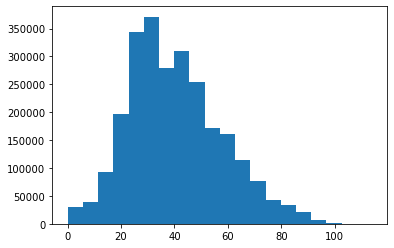

In [19]:
plt.hist(df6.edad, bins=20)

**Conversión de variables binarias a entero**

In [20]:
df7 = df6

df7["cuidado_intensivo"] = df7["cuidado_intensivo"] == "SI"
df7["asistencia_respiratoria_mecanica"] = df7["asistencia_respiratoria_mecanica"] == "SI"
df7["fallecido"] = df7["fallecido"] == "SI"

**Revisión final**

In [21]:
for i in cols:
    print(df7[i].unique())

['F' 'M']
[ 48.  23.  73.  41.  35.  43.  26.  37.  45.  54.  44.  47.  53.   8.
  30.  46.  20.  25.  32.  49.  52.  24.  27.  31.  51.  39.  61.  22.
  59.  18.  33.  62.  36.  76.  42.  34.  50.  11.  19.  28.  56.  21.
  55.  91.  16.  63.  29.  15.  58.  57.  69.  72.  40.  17.  77.  38.
  78.  68.  84.  93.  81.  64.  86.  13.  66.  83.  65.  74.  80.  60.
  12.  14.  88.  67.  82.  70.  71.  10.  79.  75.  96.   1.  89.  97.
   3.   6.   9.  98.  87.   4.   2.   5.   7.   0.  90.  85.  99.  95.
  92.  94. 101. 102. 100. 105. 108. 103. 104. 107. 106. 114.]
[False  True]
[False  True]
[False  True]


In [22]:
df7.head()

,sexo,edad,cuidado_intensivo,fallecido,asistencia_respiratoria_mecanica
16,F,48.0,False,False,False
27,F,23.0,False,False,False
51,F,73.0,False,False,False
58,F,41.0,False,False,False
60,M,35.0,False,False,False


In [23]:
target = "fallecido"
predictoras_graficas = [x for x in df7.columns.values if x not in target]

### Exploración gráfica

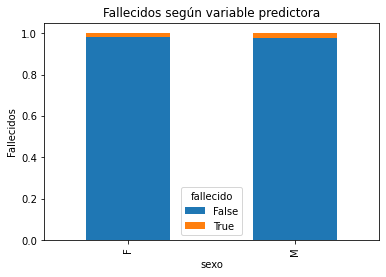

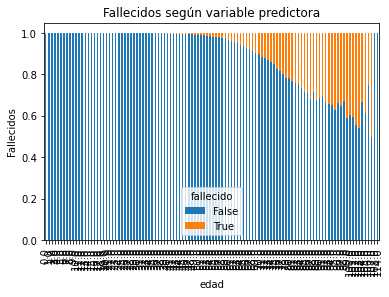

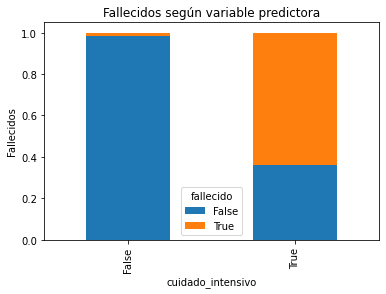

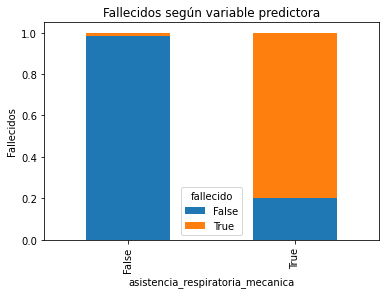

In [24]:
for var in predictoras_graficas: 
    table = pd.crosstab(df7[var], df7.fallecido)
    table.div(table.sum(1).astype(float), axis = 0).plot(kind = "bar", stacked = True)
    plt.title("Fallecidos según variable predictora")
    plt.xlabel(var)
    plt.ylabel("Fallecidos")

**Conclusiones observables**

* La mortalidad es levemente superior en el sexo masculino
* La curva por edades muestra el resultado esperado: la mortalidad aumenta con la edad
* La mortalidad es significativamente superior para los pacientes que ingresan en cuidados intensivos
* La mortalidad es significativamente superior para los pacientes que reciben asistencia respiratoria mecánica

### Elaboración de variables dummies

In [25]:
df8 = df7

categoricas = ["sexo"]

for var in categoricas:
    dummy = pd.get_dummies(df8[var], prefix=var)
    df8 = pd.concat([df8, dummy], axis = 1)
    
df8 = df8.drop(categoricas, axis = 1)
df8.head()

,edad,cuidado_intensivo,fallecido,asistencia_respiratoria_mecanica,sexo_F,sexo_M
16,48.0,False,False,False,1,0
27,23.0,False,False,False,1,0
51,73.0,False,False,False,1,0
58,41.0,False,False,False,1,0
60,35.0,False,False,False,0,1


In [26]:
df8.shape

(2546577, 6)

In [27]:
df8.fallecido.mean()*100

2.109655431585222

In [28]:
df = df8

target = "fallecido"
predictoras = [x for x in df.columns.values if x not in target]

**El dataset presenta 2546577 muestras y 6 columnas, de las cuales 5 son predictoras y 1 es target con penetración del 2.109655431585222%. Se procede a aumentar la penetración.**
### Ajuste de penetración

In [29]:
penetracion = 50

df_0 = df[df[target] == 0]
df_1 = df[df[target] == 1]

n = df_1.shape[0] * (100-penetracion)/penetracion
porc = n * 100 / df_0.shape[0]

random.seed(2403)

index = random.choices(range(len(df_0)), k = int(n))

df_0_n = df_0.iloc[index]

df_pen = pd.concat([df_1, df_0_n], axis = 0)

print(df_pen.shape[0])
print(df_pen[target].mean())

107448
0.5


### Modelado

In [30]:
df = df_pen

x = df[predictoras]
y = df[target]

lm = linear_model.LogisticRegression(max_iter=2000)
lm.fit(x, y.values.ravel())
print(lm.score(x, y) * 100)
pd.DataFrame(list(zip(x.columns, np.transpose(lm.coef_))))

88.04351872533691


,0,1
0,edad,[0.11824124917234817]
1,cuidado_intensivo,[3.86354865757526]
2,asistencia_respiratoria_mecanica,[2.488002282641897]
3,sexo_F,[-2.6460852334343254]
4,sexo_M,[-2.0924997263294]


### Validación cruzada, matriz de confusión, sensibilidad y especificidad

In [31]:
scores = cross_val_score(linear_model.LogisticRegression(max_iter=2000), x, y.values.ravel(), scoring = "average_precision", cv = 10)
df["pred"] = lm.predict(x)
confusion_matrix = pd.crosstab(df.pred, y)
TN = confusion_matrix.iloc[0][0]
FP = confusion_matrix.iloc[1][0]
FN = confusion_matrix.iloc[0][1]
TP = confusion_matrix.iloc[1][1]
sensibilidad = TP * 100 / (TP + FN)
especificidad = TN * 100 / (TN + FP)
print("La tasa de acierto tras validación cruzada es de {v:.2f}%, la sensibilidad es de {s:.2f}% y la especificidad es de {e:.2f}%".format(v=scores.mean()*100, s=sensibilidad, e=especificidad))
confusion_matrix

La tasa de acierto tras validación cruzada es de 94.26%, la sensibilidad es de 89.09% y la especificidad es de 86.99%


fallecido,False,True
pred,,
False,46737,5860
True,6987,47864


### Conclusiones

* Con una tasa de penetración del 50% se logra una tasa de acierto general superior al 88%, desglosada en:
        * Una sensibilidad superior al 89%
        * Una especificidad superior al 87%
        
* Los aumentos en la penetración aumentan la sensibilidad pero reducen la especificidad. Será decisión del usuario la elección de una mayor tasa de detección de casos graves a expensas de una menor tasa de sobreatención de casos no riesgosos, o viceversa.